## Landsat-7 surface reflectances vegetation index

This notebook derives the vegetation index (NDVI) from Landsat-7 surface reflectances L2 products.

### <a name="service">Service Definition

In [1]:
service = dict([('title', 'Landsat-7 reflectances and vegetation index'),
                ('abstract', 'Landsat-7 reflectances and vegetation index'),
                ('id', 'ewf-L7-sr-ndvi')])

### <a name="parameter">Parameter Definition 

**None**


### <a name="runtime">Runtime parameter definition

**Input reference**

This is the Landsat-7 (espa-sr) catalogue reference

In [2]:
input_reference = 'https://catalog.terradue.com/espa-sr/search?format=atom&uid=LE07_L1TP_204033_20171130_20171226_01_T1'


### <a name="workflow">Workflow

#### Import the packages required for processing the Landsat-8 vegetation indices

In [38]:
import os
import sys

from urlparse import urlparse

from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.wkt import loads
from shapely.geometry import box
import cioppy
import lxml.etree as etree
#import gdal
#import osr

#import numpy as np
from osgeo import gdal, ogr, osr

import numpy as np
from geopandas import GeoDataFrame
import pandas as pd
import geopandas as gp


### Define the AOI

In [39]:
point_of_interest = Point(-9.189, 38.733)
point_of_interest = Point(-8.914205, 38.936165)

In [40]:
buffer_size = 0.05

In [41]:
aoi_wkt = box(*point_of_interest.buffer(buffer_size).bounds)

In [42]:
aoi_wkt.wkt

'POLYGON ((-8.864205 38.88616500000001, -8.864205 38.986165, -8.964205000000002 38.986165, -8.964205000000002 38.88616500000001, -8.864205 38.88616500000001))'

In [43]:
bbox = list(aoi_wkt.bounds)
bbox

[-8.964205000000002, 38.886165000000005, -8.864205, 38.986165]

In [44]:
def eop_metadata(metadata):

    opt = 'http://www.opengis.net/opt/2.1'
    om  = 'http://www.opengis.net/om/2.0'
    gml = 'http://www.opengis.net/gml/3.2'
    eop = 'http://www.opengis.net/eop/2.1'
    sar = 'http://www.opengis.net/sar/2.1'
    
    root = etree.Element('{%s}EarthObservation' % opt)

    phenomenon_time = etree.SubElement(root, '{%s}phenomenonTime' % om)

    time_period = etree.SubElement(phenomenon_time, '{%s}TimePeriod' % gml)

    begin_position = etree.SubElement(time_period, '{%s}beginPosition'  % gml)

    end_position = etree.SubElement(time_period, '{%s}endPosition'  % gml)

    procedure = etree.SubElement(root, '{%s}procedure' % om)

    earth_observation_equipment = etree.SubElement(procedure, '{%s}EarthObservationEquipment' % eop)

    acquisition_parameters = etree.SubElement(earth_observation_equipment, '{%s}acquisitionParameters' % eop)

    acquisition = etree.SubElement(acquisition_parameters, '{%s}Acquisition' % sar)

    orbit_number = etree.SubElement(acquisition, '{%s}orbitNumber' % eop)

    wrs_longitude_grid = etree.SubElement(acquisition, '{%s}wrsLongitudeGrid' % eop)

    wrs_latitude_grid = etree.SubElement(acquisition, '{%s}wrsLatitudeGrid' % eop)
    
    
    feature_of_interest = etree.SubElement(root, '{%s}featureOfInterest' % om)
    footprint = etree.SubElement(feature_of_interest, '{%s}Footprint' % eop)
    multi_extentOf = etree.SubElement(footprint, '{%s}multiExtentOf' % eop)
    multi_surface = etree.SubElement(multi_extentOf, '{%s}MultiSurface' % gml)
    surface_members = etree.SubElement(multi_surface, '{%s}surfaceMembers' % gml)
    polygon = etree.SubElement(surface_members, '{%s}Polygon' % gml)    
    exterior = etree.SubElement(polygon, '{%s}exterior' % gml)  
    linear_ring = etree.SubElement(exterior, '{%s}LinearRing' % gml) 
    poslist = etree.SubElement(linear_ring, '{%s}posList' % gml) 


    result = etree.SubElement(root, '{%s}result' % om)
    earth_observation_result = etree.SubElement(result, '{%s}EarthObservationResult' % opt)
    cloud_cover_percentage = etree.SubElement(earth_observation_result, '{%s}cloudCoverPercentage' % opt)
    
    metadata_property = etree.SubElement(root, '{%s}metaDataProperty' % eop)
    earth_observation_metadata = etree.SubElement(metadata_property, '{%s}EarthObservationMetaData' % eop)
    identifier = etree.SubElement(earth_observation_metadata, '{%s}identifier' % eop)
    
    begin_position.text = metadata['startdate']
    end_position.text = metadata['enddate']
    orbit_number.text = metadata['orbitNumber']
    wrs_longitude_grid.text = metadata['wrsLongitudeGrid']
    wrs_latitude_grid.text = metadata['wrsLatitudeGrid']
    
    coords = np.asarray([t[::-1] for t in list(loads(metadata['wkt']).exterior.coords)]).tolist()
 
    pos_list = ''
    for elem in coords:
        pos_list += ' '.join(str(e) for e in elem) + ' '   

    poslist.attrib['count'] = str(len(coords))
    poslist.text = pos_list
    
    
    identifier.text = metadata['identifier']

    return etree.tostring(root, pretty_print=True)

#### Get the metadata of the Landsat 7 product

In [45]:
ciop = cioppy.Cioppy()

temp_results = []

search_params = dict()

search_params['do'] = 'terradue'

ls7_catalogue_metadata = ciop.search(end_point=input_reference,
                                     params=[],
                                     output_fields='enclosure,identifier,startdate,enddate,wkt,orbitNumber,swathIdentifier,wrsLongitudeGrid,wrsLatitudeGrid',
                                     model='EOP')[0]


In [46]:
ls7_catalogue_metadata

{'enclosure': 'https://store.terradue.com/espa-sr/2017/11/30/files/v1/LE07_L1TP_204033_20171130_20171226_01_T1_SR.tif',
 'enddate': '2017-11-30T11:17:14.4540000Z',
 'identifier': 'LE07_L1TP_204033_20171130_20171226_01_T1',
 'orbitNumber': '',
 'startdate': '2017-11-30T11:16:47.7000000Z',
 'swathIdentifier': '',
 'wkt': 'POLYGON((-10.28255 38.25321,-8.13736 37.94215,-7.62083 39.53916,-9.81402 39.85735,-10.28255 38.25321))',
 'wrsLatitudeGrid': '',
 'wrsLongitudeGrid': ''}

### Get the Landsat 7 product bands (geotiff)

* Get the download url
* Extract the needed bands cropping them with respect to the defined AOI

In [47]:
ls7_tif_url = ls7_catalogue_metadata['enclosure']

print ls7_tif_url

https://store.terradue.com/espa-sr/2017/11/30/files/v1/LE07_L1TP_204033_20171130_20171226_01_T1_SR.tif


In [48]:
def get_bands_geotiff(download_url, band_indices, crop=False, bbox=None):
    
    
    output = '/vsimem/clip.tif'
    
    parsed_url = urlparse(download_url)
    url = '%s://%s/api%s' % (list(parsed_url)[0], list(parsed_url)[1], list(parsed_url)[2])
    
    gdal.UseExceptions()
    gdal.SetConfigOption("GDAL_DISABLE_READDIR_ON_OPEN","YES")
    gdal.SetConfigOption("CPL_VSIL_CURL_ALLOWED_EXTENSIONS","tif")
    
    try:    
        ds = gdal.Open('/vsicurl/%s' % url)
        
    except Exception as e:
        print e
        raise
        
    if crop == True:
        print 'Cropping data...'
        ulx, uly, lrx, lry = bbox[0], bbox[3], bbox[2], bbox[1]
        ds = gdal.Translate(output, ds, bandList=band_indices, projWin = [ulx, uly, lrx, lry], projWinSRS = 'EPSG:4326')
        print 'data cropping : DONE'
        
    else:    
        ds = gdal.Translate(output, ds, bandList=band_indices)
        
    ds = None
    ds = gdal.Open(output)
    w = ds.GetRasterBand(1).XSize
    h = ds.GetRasterBand(1).YSize
    geo_transform = ds.GetGeoTransform()
    projection = ds.GetProjection()

    for i,b in enumerate(band_indices):
        
        out_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(b))
        print 'creating %s' %out_name
        
        data = ds.GetRasterBand(i+1).ReadAsArray(0, 0, w, h).astype(np.float32)
        
        bmin = data[data!=-9999].min()
        bmax = data[data!=-9999].max()
        #Let's map the data into [0.0, 1.0]
        if bmin != bmax:
            data[data!= -9999] = (data[data!=-9999] - bmin)/(bmax - bmin)
        else:
            data[data!=-9999] = 1.0
        

    
        drv = gdal.GetDriverByName('GTiff')

        ds2 = drv.Create(out_name, w, h, 1, gdal.GDT_Float32)

        ds2.SetGeoTransform(geo_transform)
        ds2.SetProjection(projection)

        ds2.GetRasterBand(1).WriteArray(data, 0, 0)
        ds2.FlushCache()

    
    ds = None
    ds2=None
    
    return

##### Landsat7 NDVI is computed with band3 and band4: (b4 - b3)/(b4 + b3)

In [49]:
band_1 = 4
band_2 = 3
band_1_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_1))
band_2_name = '%s_SR_B%s.TIF' % (ls7_catalogue_metadata['identifier'], str(band_2))

get_bands_geotiff(ls7_tif_url, [band_2,band_1], crop=True, bbox=bbox)


Cropping data...
data cropping : DONE
creating LE07_L1TP_204033_20171130_20171226_01_T1_SR_B3.TIF
creating LE07_L1TP_204033_20171130_20171226_01_T1_SR_B4.TIF


#### Compute the vegetation index with OTB tools

In [50]:
'''
sys.path.append('/opt/OTB/lib/python')
sys.path.append('/opt/OTB/lib/libfftw3.so.3')
os.environ['OTB_APPLICATION_PATH'] = '/opt/OTB/lib/otb/applications'
os.environ['LD_LIBRARY_PATH'] = '/opt/OTB/lib'
os.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB/lib/otb/applications'
os.environ['GDAL_DATA'] = '/opt/anaconda/share/gdal/'

import otbApplication
'''

"\nsys.path.append('/opt/OTB/lib/python')\nsys.path.append('/opt/OTB/lib/libfftw3.so.3')\nos.environ['OTB_APPLICATION_PATH'] = '/opt/OTB/lib/otb/applications'\nos.environ['LD_LIBRARY_PATH'] = '/opt/OTB/lib'\nos.environ['ITK_AUTOLOAD_PATH'] = '/opt/OTB/lib/otb/applications'\nos.environ['GDAL_DATA'] = '/opt/anaconda/share/gdal/'\n\nimport otbApplication\n"

In [51]:
def get_wkt(geotiff):


    src = gdal.Open(geotiff)
    
    ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()

    max_x = ulx + (src.RasterXSize * xres)
    min_y = uly + (src.RasterYSize * yres)
    min_x = ulx 
    max_y = uly
    
    source = osr.SpatialReference()
    
    source.ImportFromWkt(src.GetProjection())

    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)

    transform = osr.CoordinateTransformation(source, target)

    a = transform.TransformPoint(min_x, min_y)
    
    wkt_out = box(transform.TransformPoint(min_x, min_y)[0],
                    transform.TransformPoint(min_x, min_y)[1],
                    transform.TransformPoint(max_x, max_y)[0],
                    transform.TransformPoint(max_x, max_y)[1]).wkt
    
    
    return wkt_out

In [52]:
'''
def normalized_difference(band_1, band_2, metadata, output_name):

    metadata_name = '{0}.xml'.format(output_name)
    
    otb_app = otbApplication.Registry.CreateApplication('BandMath')
    
    otb_app.SetParameterStringList('il', [band_1, band_2])

    otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))
    
    otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')

    otb_app.ExecuteAndWriteOutput()
    
    #Set the actual wkt for NDVI 
    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))
    
    metadata['identifier'] = output_name
    
    return True
'''    

"\ndef normalized_difference(band_1, band_2, metadata, output_name):\n\n    metadata_name = '{0}.xml'.format(output_name)\n    \n    otb_app = otbApplication.Registry.CreateApplication('BandMath')\n    \n    otb_app.SetParameterStringList('il', [band_1, band_2])\n\n    otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))\n    \n    otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')\n\n    otb_app.ExecuteAndWriteOutput()\n    \n    #Set the actual wkt for NDVI \n    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))\n    \n    metadata['identifier'] = output_name\n    \n    return True\n"

In [53]:
def get_ndvi (b1, b2):
    
    ndvi = -9999
    
    if b1 >= 0 and b1 <= 1 and b2 >= 0 and b2 <= 1:
        ndvi = ( b1 - b2 ) / ( b1 + b2 )
    
    return ndvi


def load_img_to_matrix (img_path):
    
    dataset = gdal.Open(img_path)
    product_array = dataset.GetRasterBand(1).ReadAsArray()
    return product_array



def get_metadata(filepath):
    ds = gdal.Open(filepath)
    projection = ds.GetProjection()
    geotransform = ds.GetGeoTransform()
    no_data_value = ds.GetRasterBand(1).GetNoDataValue()
    data_type = ds.GetRasterBand(1).DataType
    return projection, geotransform, no_data_value, data_type



def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)
    


def normalized_difference(band_1, band_2, metadata, output_name):

    metadata_name = '{0}.xml'.format(output_name)
    
    #otb_app = otbApplication.Registry.CreateApplication('BandMath')
    
    #otb_app.SetParameterStringList('il', [band_1, band_2])

    #otb_app.SetParameterString('out', '{0}.TIF'.format(output_name))
    
    #otb_app.SetParameterString('exp', 'im1b1 >= 0 && im1b1 <= 1 && im2b1 >= 0 && im2b1 <= 1 ? ( im1b1 - im2b1 ) / ( im1b1 + im2b1 ) : -9999 ')

    #otb_app.ExecuteAndWriteOutput()
    
    
    mat_band_1 = load_img_to_matrix(band_1)
    mat_band_2 = load_img_to_matrix(band_2)
    
    
    ndvi_calculator = np.vectorize(get_ndvi)
    
    mat_ndvi = ndvi_calculator(mat_band_1, mat_band_2)
    
    
    projection, geotransform, no_data_value, data_type = get_metadata(band_1)
    
    no_data_value = -9999

    write_output_image(output_name + '.TIF', mat_ndvi, 'GTiff', data_type, None, projection, geotransform, no_data_value)
    
  
    
    
    #Set the actual wkt for NDVI 
    metadata['wkt'] = get_wkt('{0}.TIF'.format(output_name))
    
    metadata['identifier'] = output_name
    
    return True

In [54]:
output_name = '{0}_SR_{1}'.format(ls7_catalogue_metadata['identifier'],'NDVI')




normalized_difference(band_1_name,
                      band_2_name,
                      ls7_catalogue_metadata,
                      output_name)

new_identifier = ls7_catalogue_metadata['identifier']
metadata_name = '{0}.xml'.format(new_identifier)

with open(metadata_name, 'wb') as file:
    file.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    file.write(eop_metadata(ls7_catalogue_metadata)) 


In [55]:
output_name

'LE07_L1TP_204033_20171130_20171226_01_T1_SR_NDVI'

### <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.

## What follows is just to quickly visualise the results (band3, band4 and NVDI)

In [56]:
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


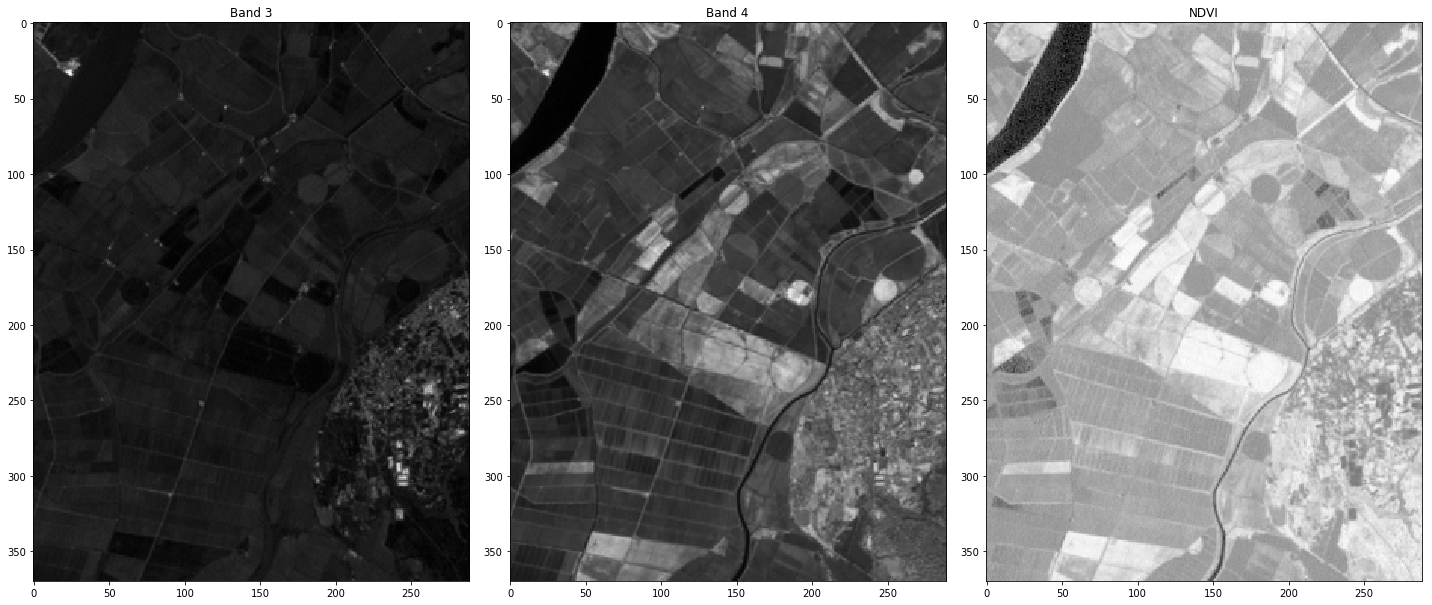

In [57]:

ds = gdal.Open(band_1_name)
band4 = ds.GetRasterBand(1).ReadAsArray()
ds=None

ds = gdal.Open(band_2_name)
band3 = ds.GetRasterBand(1).ReadAsArray()
ds=None

ds = gdal.Open('{0}.TIF'.format(output_name))
ndvi = ds.GetRasterBand(1).ReadAsArray()
ds=None

for b in [band3, band4, ndvi]:

    bmin = b[b!=-9999].min()
    bmax =  b[b!=-9999].max()
        
    if bmin != bmax:    
        b[b!=-9999] = (b[b!=-9999] - bmin)/(bmax - bmin) * 255
  
    b[b==-9999]=np.nan

fig = plt.figure(figsize=(20,20))

a = fig.add_subplot(1,3,1)
imgplot = plt.imshow(band3.astype(np.uint8),cmap='gray')
a.set_title('Band 3')

a = fig.add_subplot(1,3,2)
imgplot = plt.imshow(band4.astype(np.uint8),cmap='gray')
a.set_title('Band 4')

a = fig.add_subplot(1,3,3)
imgplot = plt.imshow(ndvi.astype(np.uint8),cmap='gray')
a.set_title('NDVI')

plt.tight_layout()
fig = plt.gcf()
plt.show()

fig.clf()
plt.close()
